In [11]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)

from jaxgym import lens_step, propagate, Ray

We are going to start with a slightly more general approach, that should amount to the same output in the end as your torch code. It will just be a bit more general so it should be more useful later. 

We are going to use Jax to compute the Jacobian of the output ray positions and slopes with respect to the input ray positions and slopes:

Essential the partial derivative of output parameters with respect to input parameters, which is more or less what torch was giving you too, for now we are just being somewhat more explicit about it, and what it means for our rays. 

For an input matrix of 1 x 5 (containing (x, x', y, y', 1) input ray parameters with primes denoting input slopes), the Jacobian will be a 5x5 matrix of this form:



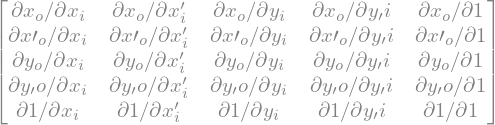

In [13]:
import sympy as sp
sp.init_printing()
# Define input variables
x, dx, y, dy = sp.symbols('x_{i} x^{\\prime}_{i} y_{i} y_{\\prime}{i}')

# Define output variables symbolically
x_o, dx_o, y_o, dy_o = sp.symbols('x_{o} x{\\prime}_{o} y_{o} y_{\\prime}{o}')

# Construct symbolic partial derivatives for Jacobian matrix
partial = lambda f, v: sp.Symbol(f'\\partial {f} / \\partial {v}')  # LaTeX style partial symbols

# Input and output variable lists
input_vars = [x, dx, y, dy, 1]
output_vars = [x_o, dx_o, y_o, dy_o, 1]

# Create a matrix of symbolic partial derivatives
jacobian_symbolic = sp.Matrix([
    [partial(str(f), str(v)) for v in input_vars] for f in output_vars
])

# Display the Jacobian as a matrix of partial derivatives
display(jacobian_symbolic)



In linear ray transfer matrix terms, this jacobian will be equivalent to the transfer matrix of the system: For instance, if we have a series of propagation steps and components such as lenses, the jacobian will equal the matrix multiplication of all of those transfer matrices. 

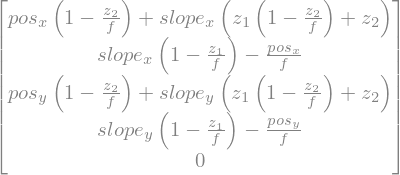

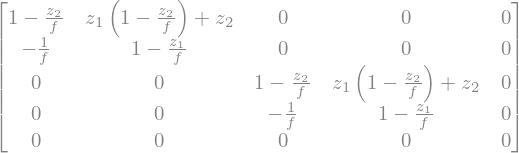

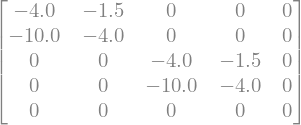

In [14]:
import sympy as sp
sp.init_printing()

# Step 1: Define symbolic variables
pos_x, slope_x, pos_y, slope_y, _ = sp.symbols('pos_x slope_x pos_y slope_y _')
f, z1, z2 = sp.symbols('f z1 z2')  # focal length of the lens

# Step 2: Define the lens transformation matrix (5x5 matrix with -1/f)
transfer_matrix_1 = sp.Matrix([
    [1, z1, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, z1, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0]
])
lens_matrix = sp.Matrix([
    [1, 0, 0, 0, 0],
    [-1 / f, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, -1/f, 1, 0],  # -1/f term affecting slope_y
    [0, 0, 0, 0, 0]
])
transfer_matrix_2 = sp.Matrix([
    [1, z2, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, z2, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0]
])
# Step 3: Define the input vector (5x1)
input_vector = sp.Matrix([pos_x, slope_x, pos_y, slope_y, _])

# Step 4: Compute the output vector by multiplying the lens matrix with the input vector
output_vector = transfer_matrix_2 @ lens_matrix @ transfer_matrix_1 @ input_vector

display(output_vector)
# Step 5: Compute the Jacobian
# Since the transformation is linear, the Jacobian is simply the lens matrix
# Step 5: Compute the Jacobian using sympy's jacobian method
jacobian_sympy = sp.Matrix.jacobian(output_vector, input_vector)
display(jacobian_sympy)

# Step 7: Substitute the values of the variables
jacobian_sympy = jacobian_sympy.subs({f: 0.1, z1: 0.5, z2: 0.5})

display(jacobian_sympy)

These matrices are equivalent for a linear system. 

$\displaystyle \left[\begin{matrix}\partial x_{o} / \partial x_{i} & \partial x_{o} / \partial x^{\prime}_{i} & \partial x_{o} / \partial y_{i} & \partial x_{o} / \partial y_{\prime}{i} & \partial x_{o} / \partial 1\\\partial x{\prime}_{o} / \partial x_{i} & \partial x{\prime}_{o} / \partial x^{\prime}_{i} & \partial x{\prime}_{o} / \partial y_{i} & \partial x{\prime}_{o} / \partial y_{\prime}{i} & \partial x{\prime}_{o} / \partial 1\\\partial y_{o} / \partial x_{i} & \partial y_{o} / \partial x^{\prime}_{i} & \partial y_{o} / \partial y_{i} & \partial y_{o} / \partial y_{\prime}{i} & \partial y_{o} / \partial 1\\\partial y_{\prime}{o} / \partial x_{i} & \partial y_{\prime}{o} / \partial x^{\prime}_{i} & \partial y_{\prime}{o} / \partial y_{i} & \partial y_{\prime}{o} / \partial y_{\prime}{i} & \partial y_{\prime}{o} / \partial 1\\\partial 1 / \partial x_{i} & \partial 1 / \partial x^{\prime}_{i} & \partial 1 / \partial y_{i} & \partial 1 / \partial y_{\prime}{i} & \partial 1 / \partial 1\end{matrix}\right]$ = $\displaystyle \left[\begin{matrix}1 - \frac{z_{2}}{f} & z_{1} \left(1 - \frac{z_{2}}{f}\right) + z_{2} & 0 & 0 & 0\\- \frac{1}{f} & 1 - \frac{z_{1}}{f} & 0 & 0 & 0\\0 & 0 & 1 - \frac{z_{2}}{f} & z_{1} \left(1 - \frac{z_{2}}{f}\right) + z_{2} & 0\\0 & 0 & - \frac{1}{f} & 1 - \frac{z_{1}}{f} & 0\\0 & 0 & 0 & 0 & 1\end{matrix}\right]$

Now as you mentioned in the torch notebook, there should be no restriction on matrix use, but more complicated functions should be possible. The nice thing about torch or jax and the jacobian, is that autodiff will give us the jacobian for every ray in the system, and that ray need not have been propagated via a ray transfer matrix, just as long as the operations are linear we will automatically get the Jacobian for that ray. What this means also is that the scan decscan system can have a complicated function to apply descan error, but what that does to each ray in it's tilting or shifting will just appear in the final column of the jacobian matrix as a tilt or shift error. And everything we need to know about how to propagate that ray backwards is found by just inverting that jacobian. 

In [19]:
SOURCE = 0
LENS = 1
DETECTOR = 2

def run_model(ray, model_params):
    for component in model_params:
        component_type = model_params[component]['type']
        z = model_params[component]['z']

        distance = z - ray.z
        ray = propagate(distance, ray)

        if component_type == SOURCE:
            pass
        if component_type == LENS:
            lens_params = model_params[component]
            ray = lens_step(lens_params, ray)
        elif component_type == DETECTOR:
            pass
        
    return ray.matrix

input_matrix = jnp.array([[0.1, 0.0, 0., 0., 1.]])
input_amplitude = 1.0
input_pathlength = 0.0
input_wavelength = 1.0

ray_input = Ray(z=0.0,
                matrix = input_matrix, 
                amplitude = input_amplitude, 
                pathlength = input_pathlength, 
                wavelength = input_wavelength)

source_1_params = {'type': SOURCE,
                    'z': 0.0,
                  }

lens_1_params = {'type': LENS,
                 'z': 0.5, 
                 'focal_length': 0.1}

detector_1_params = {'type': DETECTOR,
                    'z': 1., 
                    'shape': (100, 100), 
                    'px_size': 0.01, 
                    'centre_yx': (0., 0.)}

model_params = {'source_1': source_1_params,
                'lens_1': lens_1_params,
                'detector_1': detector_1_params}

dro_dri = jax.jacobian(run_model, argnums=0)(ray_input, model_params)
dro_dparams = jax.jacobian(run_model, argnums=1, allow_int=True)(ray_input, model_params)

In [21]:
print(dro_dparams['lens_1']['focal_length'])

ray_transfer_matrix_jax = dro_dri.matrix.squeeze()
ray_transfer_matrix_sympy = np.array(jacobian_sympy).astype(np.float64)

print(ray_transfer_matrix_jax), print(ray_transfer_matrix_sympy)

[[-5. 10.  0.  0.  0.]]
[[ -4.   -1.5   0.    0.    0. ]
 [-10.   -4.    0.    0.    0. ]
 [  0.    0.   -4.   -1.5   0. ]
 [  0.    0.  -10.   -4.    0. ]
 [  0.    0.    0.    0.    0. ]]
[[ -4.   -1.5   0.    0.    0. ]
 [-10.   -4.    0.    0.    0. ]
 [  0.    0.   -4.   -1.5   0. ]
 [  0.    0.  -10.   -4.    0. ]
 [  0.    0.    0.    0.    0. ]]


(None, None)

In [18]:
import numpy.testing as npt

jacobian_sympy_np = np.array(jacobian_sympy).astype(np.float64)
npt.assert_allclose(ray_transfer_matrix_jax, jacobian_sympy_np, atol=1e-7)
